In [2]:
# Instalar Mesa
!pip install mesa -q

print("✓ Mesa instalado correctamente")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.9/239.9 kB 6.4 MB/s eta 0:00:00
✓ Mesa instalado correctamente


In [24]:
"""
Modelo de Robot de Limpieza Reactivo
Simulación de agentes (robots) que limpian una habitación con celdas sucias

Autores: [Tu nombre] - [Tu matrícula]
Fecha: 14 de Noviembre, 2024
"""

import mesa
from mesa.discrete_space import CellAgent, OrthogonalMooreGrid
import matplotlib.pyplot as plt
import numpy as np

In [26]:
class CeldaHabitacion:
    """
    Representa una celda en la habitación que puede estar sucia o limpia.
    """
    def __init__(self, pos, sucia=False):
        """
        Inicializa una celda.

        Args:
            pos: Tupla (x, y) con la posición
            sucia: Boolean, True si la celda está sucia
        """
        self.pos = pos
        self.sucia = sucia

    def limpiar(self):
        """Limpia la celda."""
        self.sucia = False

    def ensuciar(self):
        """Ensucia la celda."""
        self.sucia = True

In [28]:
class RobotLimpieza(CellAgent):
    """
    Un agente robot que limpia celdas sucias o se mueve aleatoriamente.
    """
    def __init__(self, model, cell):
        """
        Inicializa un robot de limpieza.

        Args:
            model: Instancia del modelo
            cell: Celda donde inicia el robot
        """
        super().__init__(model)
        self.cell = cell
        self.movimientos = 0

    def limpiar_celda_actual(self):
        """
        Limpia la celda actual si está sucia.

        Returns:
            True si limpió, False si ya estaba limpia
        """
        pos = self.cell.coordinate
        celda = self.model.celdas_estado[pos]

        if celda.sucia:
            celda.limpiar()
            return True
        return False

    def mover(self):
        """
        Mueve el robot a una celda vecina aleatoria (8 vecinos - Moore).
        """
        vecinos = list(self.cell.neighborhood.cells)

        if vecinos:
            nueva_celda = self.random.choice(vecinos)
            self.cell = nueva_celda
            self.movimientos += 1

    def step(self):
        """
        Ejecuta un paso del robot:
        1. Si la celda está sucia -> limpia
        2. Si la celda está limpia -> se mueve
        """
        pos = self.cell.coordinate
        celda = self.model.celdas_estado[pos]

        if celda.sucia:
            self.limpiar_celda_actual()
        else:
            self.mover()

In [30]:
def obtener_celdas_sucias(model):
    """Cuenta cuántas celdas están sucias."""
    celdas_sucias = sum(1 for celda in model.celdas_estado.values() if celda.sucia)
    return celdas_sucias

def calcular_porcentaje_limpio(model):
    """Calcula el porcentaje de celdas limpias."""
    total_celdas = model.width * model.height
    celdas_sucias = obtener_celdas_sucias(model)
    celdas_limpias = total_celdas - celdas_sucias
    porcentaje = (celdas_limpias / total_celdas) * 100
    return porcentaje

def contar_movimientos_totales(model):
    """Suma todos los movimientos de todos los robots."""
    return sum(robot.movimientos for robot in model.agents)


In [31]:
class CleaningModel(mesa.Model):
    """Modelo de limpieza con robots reactivos."""

    def __init__(self, num_agentes=5, width=10, height=10,
                 porcentaje_sucias=0.3, max_steps=1000, seed=None):
        super().__init__(seed=seed)

        self.num_agentes = num_agentes
        self.width = width
        self.height = height
        self.max_steps = max_steps
        self.steps = 0
        self.terminado = False

        # Crear la grilla
        self.grid = OrthogonalMooreGrid((width, height), random=self.random)

        # Diccionario de estados de celdas
        self.celdas_estado = {}

        # Inicializar todas las celdas como limpias
        for x in range(width):
            for y in range(height):
                self.celdas_estado[(x, y)] = CeldaHabitacion((x, y), sucia=False)

        # Ensuciar aleatoriamente
        total_celdas = width * height
        num_sucias = int(total_celdas * porcentaje_sucias)
        todas_posiciones = list(self.celdas_estado.keys())
        posiciones_sucias = self.random.sample(todas_posiciones, num_sucias)

        for pos in posiciones_sucias:
            self.celdas_estado[pos].ensuciar()

        # Crear robots en posición inicial [0, 0]
        celda_inicial = self.grid[(0, 0)]
        RobotLimpieza.create_agents(
            self,
            self.num_agentes,
            [celda_inicial] * self.num_agentes
        )

        # DataCollector
        self.datacollector = mesa.DataCollector(
            model_reporters={
                "Celdas Sucias": obtener_celdas_sucias,
                "Porcentaje Limpio": calcular_porcentaje_limpio,
                "Movimientos Totales": contar_movimientos_totales
            },
            agent_reporters={"Movimientos": "movimientos"}
        )

        self.datacollector.collect(self)

    def step(self):
        """Ejecuta un paso del modelo."""
        self.steps += 1
        self.agents.shuffle_do("step")
        self.datacollector.collect(self)

        if obtener_celdas_sucias(self) == 0:
            self.terminado = True
            print(f"¡Todas las celdas limpias en {self.steps} pasos!")

        if self.steps >= self.max_steps:
            self.terminado = True
            print(f"Máximo de pasos alcanzado ({self.max_steps})")

    def run_model(self, max_steps=None):
        """Ejecuta el modelo hasta terminar."""
        if max_steps is None:
            max_steps = self.max_steps

        for i in range(max_steps):
            if self.terminado:
                break
            self.step()

In [37]:
# Crear modelo
modelo_largo = CleaningModel(
    num_agentes=5,
    width=10,
    height=10,
    porcentaje_sucias=0.4,
    max_steps=500,
    seed=42
)

print("=== MODELO CON 500 PASOS ===")
modelo_largo.run_model()

print(f"\nPasos usados: {modelo_largo.steps}")
print(f"Celdas sucias finales: {obtener_celdas_sucias(modelo_largo)}")
print(f"% Limpio: {calcular_porcentaje_limpio(modelo_largo):.2f}%")
print(f"Movimientos totales: {contar_movimientos_totales(modelo_largo)}")

=== MODELO CON 500 PASOS ===
¡Todas las celdas limpias en 416 pasos!

Pasos usados: 416
Celdas sucias finales: 0
% Limpio: 100.00%
Movimientos totales: 1000


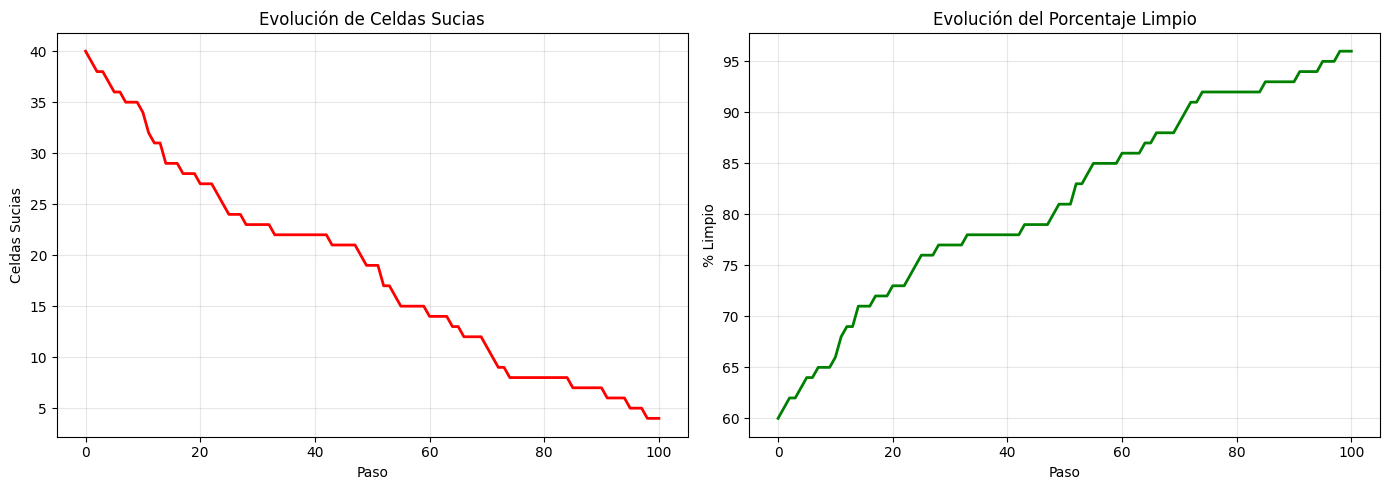

In [38]:
# Obtener datos
datos = modelo.datacollector.get_model_vars_dataframe()

# Crear gráficas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Celdas sucias
ax1.plot(datos.index, datos["Celdas Sucias"], 'r-', linewidth=2)
ax1.set_xlabel('Paso')
ax1.set_ylabel('Celdas Sucias')
ax1.set_title('Evolución de Celdas Sucias')
ax1.grid(True, alpha=0.3)

# Porcentaje limpio
ax2.plot(datos.index, datos["Porcentaje Limpio"], 'g-', linewidth=2)
ax2.set_xlabel('Paso')
ax2.set_ylabel('% Limpio')
ax2.set_title('Evolución del Porcentaje Limpio')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()